# Predicting Baklava Cravings: A Sweet Data Science Problem 🍭

Did you know that Istanbul alone devours a staggering 2,000 tons of baklava during the festive season? That's a lot of sweet treats!

To ensure that bakeries and retailers can meet this incredible demand without overproducing or understocking, we can leverage the power of data science. By analyzing historical sales data, consumer trends, and external factors like holidays, we can build a predictive model to forecast baklava demand with impressive accuracy.

# 🐠 Install & Import packages
We will need to install and import packages as we develop our model.

This will take a couple of minutes, and if pip gives any error, don't worry about it. Things will just run fine regardless.

In [1]:
!pip -q install keras "tensorflow==2.15.1" "tf2onnx" "onnx" "seaborn" "onnxruntime"


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [15]:
from pathlib import Path
import pickle
import os
import logging, warnings

# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import tf2onnx
import onnx
import tensorflow as tf
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from matplotlib import pyplot as plt
import onnxruntime as ort


# Suppress CUDA and TF warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=FutureWarning)

# 📦 Load Data
Let's load our dataset, that consist of baklava consumption information alongside the number of bakeries for the past 10 years in different regions of Türkiye.

Then we will select the input and output data.

In [4]:
# Load the data
data = pd.read_csv("synthetic_baklava_data_turkey.csv")

In [5]:
# Feature Engineering
data['Population_per_Bakery'] = data['Population'] / data['Bakery_Count'] 

In [ ]:
# One-hot encode the 'Region' column
region_encoder = OneHotEncoder(sparse_output=False)
region_encoded = region_encoder.fit_transform(data[["Region"]])
region_encoded_df = pd.DataFrame(region_encoded, columns=region_encoder.get_feature_names_out(["Region"]))
data = pd.concat([data, region_encoded_df], axis=1)

In [8]:
# Get list of regions
regions = list(data.columns[data.columns.str.startswith('Region_')])


Input data (X) contains baklava consumption per region in the country in each day, with a detail whether it was a holiday season or not.

Output data (y) is the target variable the model is trying to predict. In this case, y is the 'Demand' column which represents the demand for the upcoming holiday season. The model will learn to predict the demand based on the previous consumptions.

In [9]:
# Prepare data for modeling
features = ['Holiday_Promotion', 'Population_per_Bakery', 'Income_Level', 'Holiday_Season'] + regions
X = data[features] 
y = data['Demand']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🚀 Build the model

This is where we need your help! Experimentation and exploration are key to finding the best settings for our specific dataset and problem. 

Below 4 little parameteres that are called as hyperparameters and we need your help to define the best settings for the model!

It has some good starting values, but they can be better for sure!

In [ ]:
# Epochs represents the number of times the model sees the entire training dataset. 
# Higher values can improve accuracy but may also lead to overfitting.
epochs = 50  

# batch_size is the number of samples processed before the model updates its internal parameters. 
# # Larger batch sizes can speed up training but may require more memory.
batch_size = 16  

# learning_rate controls the step size during weight updates. 
# Higher values can lead to faster convergence but may cause instability if too high.
learning_rate = 0.001  

# Number of neurons in the hidden layer. For simpler problems, fewer neurons may suffice. 
# For more complex problems, a larger number of neurons may be necessary.
# value can be 16, 32, 64..
hidden_layer_units = 16

The below piece of code is the model definition. It will uses the parameters you define up there and learned to predict the demand as accurately as possible.

Then, we check how well the model is doing at making the guesses!

In [21]:
# Function to train and evaluate a neural network model
def train_and_evaluate_nn():
  """
  Trains and evaluates a simple neural network model.

  Returns:
      tuple: A tuple containing the Mean Squared Error (MSE) and Mean Absolute Error (MAE) of the model.
  """

  # Define the model architecture
  model = Sequential()
  model.add(Dense(hidden_layer_units, activation='relu', input_shape=(X_train_scaled.shape[1],))) 
  # Hidden layer with ReLU activation for non-linearity
  model.add(Dense(1))  # Output layer

  # Compile the model
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate) 
  model.compile(loss='mean_squared_error', optimizer=optimizer)

  # Train the model
  history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

  # Make predictions
  y_pred = model.predict(X_test_scaled)

  # Calculate metrics
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)

  print(f"Epochs: {epochs}")
  print(f"Batch Size: {batch_size}")
  print(f"Learning Rate: {learning_rate}")
  print(f"Hidden Layer Units: {hidden_layer_units}")
  print(f"Mean Squared Error: {mse}")
  print(f"Mean Absolute Error: {mae}")

  # Plot training history
  plt.plot(history.history['loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

  return model, mse, mae

# 🏃 Train & Evaluate the Model

Let's kick of the training then! You'll a nice plot and 2 important metrics to decide how well your parameters did.


### Interpretation of the Loss Plot
**X-axis:** Represents the number of training epochs.

**Y-axis:** Represents the training loss, which measures how well the model is fitting the training data. A lower loss generally indicates better performance.

**Decreasing Loss:** Ideally, the plot should show a downward trend, indicating that the model is learning and improving.

**Plateau/Increase:** If the loss plateaus or starts to increase, it might suggest overfitting or an inappropriate learning rate.

Experimentation and exploration are key to finding the best hyperparameter values for your specific dataset and problem.

7/7 [==============================] - 0s 2ms/step
Epochs: 100
Batch Size: 32
Learning Rate: 0.001
Hidden Layer Units: 64
Mean Squared Error: 109708715.75228554
Mean Absolute Error: 9365.02390234906


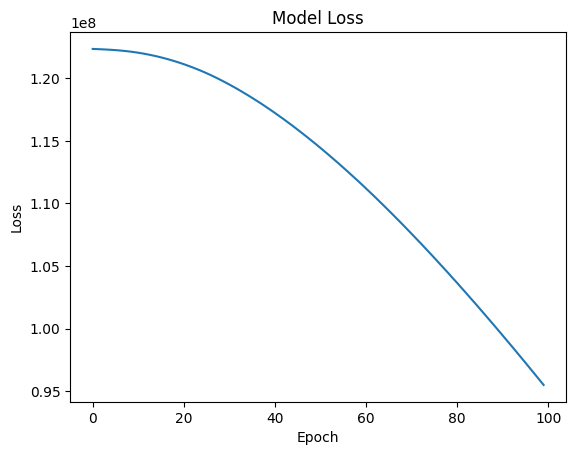

In [22]:
# Train and evaluate the model
model, mse, mae = train_and_evaluate_nn() 


# 🫡 Save the Model

Here we convert our trained prediction model into a popular format called ONNX so we can serve it from OpenShift AI.

In [ ]:
# Specify the version
version = "<YOUR_VERSION>"

# Create the artifacts directory if it doesn't exist
artifact_path = f"models/{version}/baklava/1"
Path(artifact_path).mkdir(parents=True, exist_ok=True)

# Save the model to ONNX format
onnx_model, _ = tf2onnx.convert.from_keras(
    model, 
    input_signature=[tf.TensorSpec([None, X_train_scaled.shape[1]], tf.float32, name='input')]
)
onnx.save(onnx_model, f"{artifact_path}/model.onnx")

# Save the scaler
joblib.dump(scaler, f"{artifact_path}/artifacts/scaler.pkl")

['models/baklava/1/artifacts/scaler.pkl']

# 📫 Store Your Experiment and Deploy the BEST one

Now, we need you to store below information in Model Registry for each of your experiment:

- Model version
- Model URI
- Number of Epochs
- Batch Size
- Learning Rate
- Hidden Layer Units
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)